In [472]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import alepython.ale
from sklearn.inspection import PartialDependenceDisplay
import seaborn as sns

In [696]:
# Load dataset
df = pd.read_csv(".../processed_model01.csv", delimiter=";")

In [704]:
# Define numerical and categorical columns
numerical_cols = ['duration', 'credit_amount', 'installment_rate', 'residence_duration', 'age', 'number_of_credits', 'people_liable']
categorical_cols = ['status', 'credit_history', 'purpose', 'savings/bonds', 'employment_duration', 'personal_status_and_sex',
                    'other_debtors', 'property', 'installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']

In [706]:
# Apply one-hot encoding to categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols)

In [708]:
final_columns = numerical_cols + [col for col in df_encoded.columns if col not in numerical_cols + ['credit_risk', 'predicted_label']] + ['credit_risk', 'predicted_label']
df_encoded = df_encoded[final_columns]

In [710]:
df_encoded.columns

Index(['duration', 'credit_amount', 'installment_rate', 'residence_duration',
       'age', 'number_of_credits', 'people_liable', 'id', 'status_1.0',
       'status_2.0', 'status_3.0', 'status_4.0', 'credit_history_0.0',
       'credit_history_1.0', 'credit_history_2.0', 'credit_history_3.0',
       'credit_history_4.0', 'purpose_0.0', 'purpose_1.0', 'purpose_2.0',
       'purpose_3.0', 'purpose_4.0', 'purpose_5.0', 'purpose_6.0',
       'purpose_8.0', 'purpose_9.0', 'purpose_10.0', 'savings/bonds_1.0',
       'savings/bonds_2.0', 'savings/bonds_3.0', 'savings/bonds_4.0',
       'savings/bonds_5.0', 'employment_duration_1.0',
       'employment_duration_2.0', 'employment_duration_3.0',
       'employment_duration_4.0', 'employment_duration_5.0',
       'personal_status_and_sex_1.0', 'personal_status_and_sex_2.0',
       'personal_status_and_sex_3.0', 'personal_status_and_sex_4.0',
       'other_debtors_1.0', 'other_debtors_2.0', 'other_debtors_3.0',
       'property_1.0', 'property_2.0

In [712]:
df_encoded = df_encoded.dropna()

In [714]:
X = df_encoded.drop(columns=['credit_risk','id', 'predicted_label'])  # Features
y_pred = df_encoded['predicted_label']  # Model's given predictions

In [503]:
df_encoded.to_csv("df_encoded.csv")

In [716]:
X

,duration,credit_amount,installment_rate,residence_duration,age,number_of_credits,people_liable,status_1.0,status_2.0,status_3.0,...,housing_2.0,housing_3.0,job_1.0,job_2.0,job_3.0,job_4.0,telephone_1.0,telephone_2.0,foreign_worker_1.0,foreign_worker_2.0
0,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,False,True,False,...,True,False,False,False,True,False,True,False,True,False
1,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,False,False,False,...,True,False,False,True,False,False,True,False,True,False
2,24.0,2835.0,3.0,4.0,53.0,1.0,1.0,False,False,False,...,True,False,False,False,True,False,True,False,True,False
3,48.0,4308.0,3.0,4.0,24.0,1.0,1.0,True,False,False,...,False,False,False,False,True,False,True,False,True,False
4,24.0,1199.0,4.0,4.0,60.0,2.0,1.0,True,False,False,...,True,False,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,24.0,6579.0,4.0,2.0,29.0,1.0,1.0,True,False,False,...,False,True,False,False,False,True,False,True,True,False
296,18.0,1936.0,2.0,4.0,23.0,2.0,1.0,True,False,False,...,False,False,False,True,False,False,True,False,True,False
297,36.0,3959.0,4.0,3.0,30.0,1.0,1.0,True,False,False,...,True,False,False,False,False,True,False,True,True,False
298,30.0,3857.0,4.0,4.0,40.0,1.0,1.0,True,False,False,...,True,False,False,False,False,True,False,True,True,False


In [718]:
y_pred

0      1.0
1      0.0
2      0.0
3      1.0
4      0.0
      ... 
295    1.0
296    0.0
297    1.0
298    1.0
299    1.0
Name: predicted_label, Length: 300, dtype: float64

In [720]:
X_shap = X.copy()

> ## Permutation Importance



**Correlation-Based (High Scores)**
- Computes **absolute correlation** between `X` and `y_pred`.
- **Not model-based** → may overestimate importance.

**Permutation Importance (Low Scores)**
- **Shuffles each feature** → checks model performance drop.
- **More reliable** but typically lower values.

In [722]:
# Fill missing values
X = X.fillna(0)

# Compute correlation between features and predictions (y_pred)
importance_scores = {}
for col in X.columns:
    importance_scores[col] = abs(np.corrcoef(X[col], y_pred)[0, 1])  # Absolute correlation

importance_df = pd.DataFrame.from_dict(importance_scores, orient="index", columns=["Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

Top 10 Important Features
                    Importance
status_1.0            0.471985
status_4.0            0.461726
duration              0.378359
savings/bonds_1.0     0.307489
credit_history_0.0    0.305588
credit_history_4.0    0.265057
credit_amount         0.246435
savings/bonds_5.0     0.235927
property_1.0          0.230690
property_4.0          0.169591


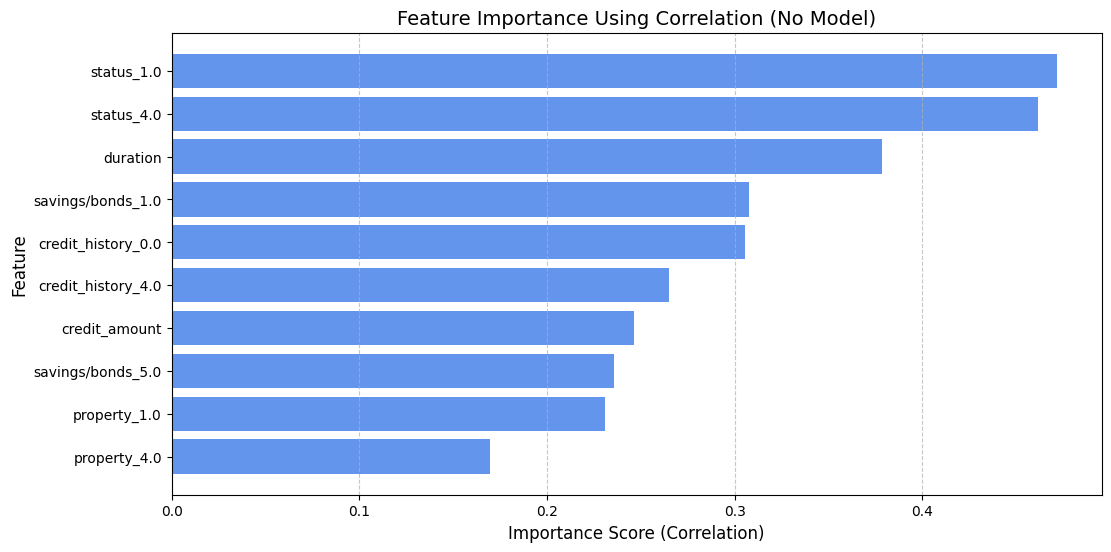

In [726]:
# Ensure importance_scores is a dictionary
if not isinstance(importance_scores, dict):
    raise ValueError("Error: importance_scores must be a dictionary.")

# Convert to DataFrame and sort
importance_df = pd.DataFrame.from_dict(importance_scores, orient="index", columns=["Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Check if DataFrame is empty
if importance_df.empty:
    print("Warning: No features were ranked.")
else:
    # Display the top 10 important features
    top_10_features = importance_df.head(10)
    print("Top 10 Important Features")
    print(top_10_features)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.barh(top_10_features.index, top_10_features["Importance"], color="cornflowerblue")
    plt.xlabel("Importance Score (Correlation)", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.title("Feature Importance Using Correlation (No Model)", fontsize=14)
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()


/Users/dilara/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                        Feature  Importance
9                    status_4.0    0.082333
0                      duration    0.050667
26            savings/bonds_5.0    0.029333
2              installment_rate    0.022333
32  personal_status_and_sex_3.0    0.021667
1                 credit_amount    0.019000
13           credit_history_4.0    0.018333
40        installment_plans_3.0    0.017000
41                  housing_2.0    0.014667
37                 property_3.0    0.013667


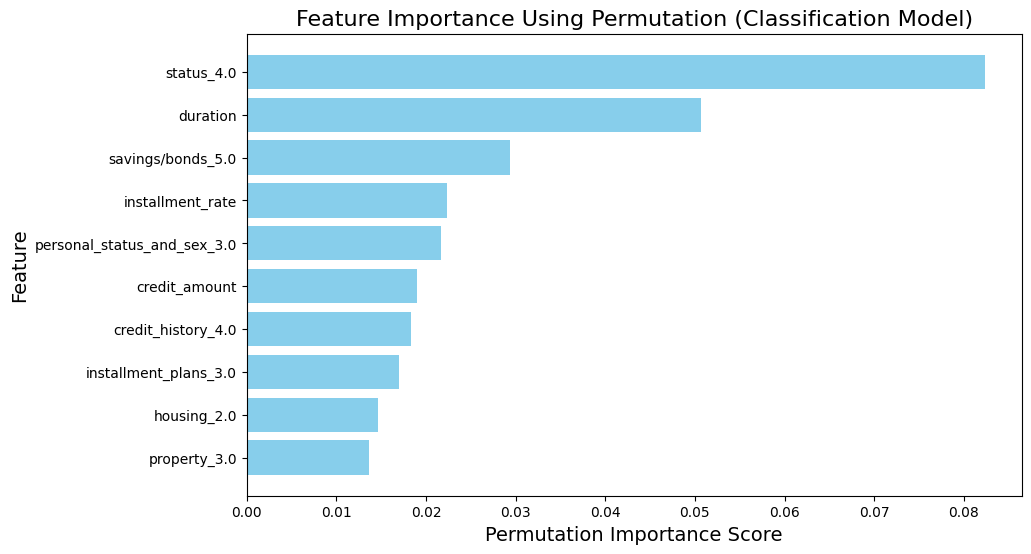

In [438]:
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression  # A better baseline than DummyRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#
baseline_model = LogisticRegression()
baseline_model.fit(X_shap, y_pred)  # Fit using features & predicted labels

#Compute permutation importance using classification scoring
perm_importance = permutation_importance(
    baseline_model,  
    X_shap,
    y_pred,
    scoring="accuracy",  # Use accuracy for binary classification
    n_repeats=10,  # Number of random shuffles
    random_state=42
)

# Convert results into a DataFrame
importance_df = pd.DataFrame({
    "Feature": X_shap.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

#Print Feature Importance Rankings
print(importance_df.head(10))

#Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"].head(10), importance_df["Importance"].head(10), color="skyblue")
plt.xlabel("Permutation Importance Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.title("Feature Importance Using Permutation (Classification Model)", fontsize=16)
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

### Feature Importance: Protected vs. Economic vs. Housing

### First:
Compare the impact of **proted variables (age, sex, etc.)** against **economic, housing, and all variables together** using:
- **SHAP values**
- **Permutation Importance**

---

### Feature Groups
1. **Protected Variables:** `["age", "personal_status_and_sex", "job", "foreign_worker"]`
2. **Economic Variables:** `["credit_amount", "savings/bonds", "employment_duration", "installment_rate"]`
3. **Housing Variables:** `["housing", "property", "people_liable", "number_of_credits"]`
4. **All Features:** Full dataset for comparison.

---

### Method
- **Train model separately** for each feature set.
- **Compute SHAP values** for global interpretability.
- **Use Permutation Importance** to measure effect on accuracy.

---

- **SHAP Summary Plot:** Shows global impact of each feature.
- **Permutation Importance Plot:** Compares effect on accuracy.



In [735]:
df2 = df_encoded.drop(columns=["id"])


In [737]:
#define feature groups
protected_vars = ["age"] + [col for col in df2.columns if "personal_status_and_sex" in col or "foreign_worker" in col or "job" in col]
economic_vars = ["credit_amount", "installment_rate"] + [col for col in df2.columns if "employment_duration" in col or "savings/bonds" in col]
housing_vars = ["housing_1.0", "housing_2.0", "housing_3.0", "residence_duration", "people_liable"] + [col for col in df2.columns if "property" in col]
all_features = list(set(df2.columns) - set(["credit_risk", "predicted_label"]))

In [739]:
def evaluate_feature_importance(X, y, feature_set, name):
    X_subset = X[feature_set]
    
    #train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_subset, y)
    plt.figure(figsize=(12, 8))
    #SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_subset)
    
    if isinstance(shap_values, list):  # If model has multiple outputs
        shap.summary_plot(shap_values[0], X_subset, feature_names=X_subset.columns, show=False)  #first output
    else:
        shap.summary_plot(shap_values, X_subset, feature_names=X_subset.columns, show=False)  #use directly if single output
    plt.title(f"SHAP Summary Plot for {name} Feature Set", fontsize=14)
    plt.show()  
    #Permutation Importance
    perm_importance = permutation_importance(model, X_subset, y, scoring='accuracy', random_state=42)
    
    #DataFrame
    importance_df = pd.DataFrame({
        "Feature": X_subset.columns,
        "Importance": perm_importance.importances_mean
    }).sort_values(by="Importance", ascending=False)
    
    #plot
    plt.figure(figsize=(10, 5))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="cornflowerblue")
    plt.xlabel("Permutation Importance Score")
    plt.title(f"Feature Importance Using Permutation ({name})")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
   
    plt.show()
    
    return importance_df

In [741]:
#prepare data
X = df2.drop(columns=["credit_risk", "predicted_label"])
y = df2["credit_risk"].astype(int)  # Ensure binary classification


The plot is an interaction plot, meaning it shows how this feature interacts with others. If the points are clustered around zero, it suggests little interaction with other features.


/var/folders/ly/zhl3dp793873w6fqch3l_7g80000gn/T/ipykernel_48014/3529847050.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_subset, feature_names=X_subset.columns, show=False)  # Use directly if single output
/Users/dilara/.julia/conda/3/lib/python3.9/site-packages/shap/plots/_beeswarm.py:718: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/Users/dilara/.julia/conda/3/lib/python3.9/site-packages/shap/plots/_beeswarm.py:738: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` exp

<Figure size 1200x800 with 0 Axes>

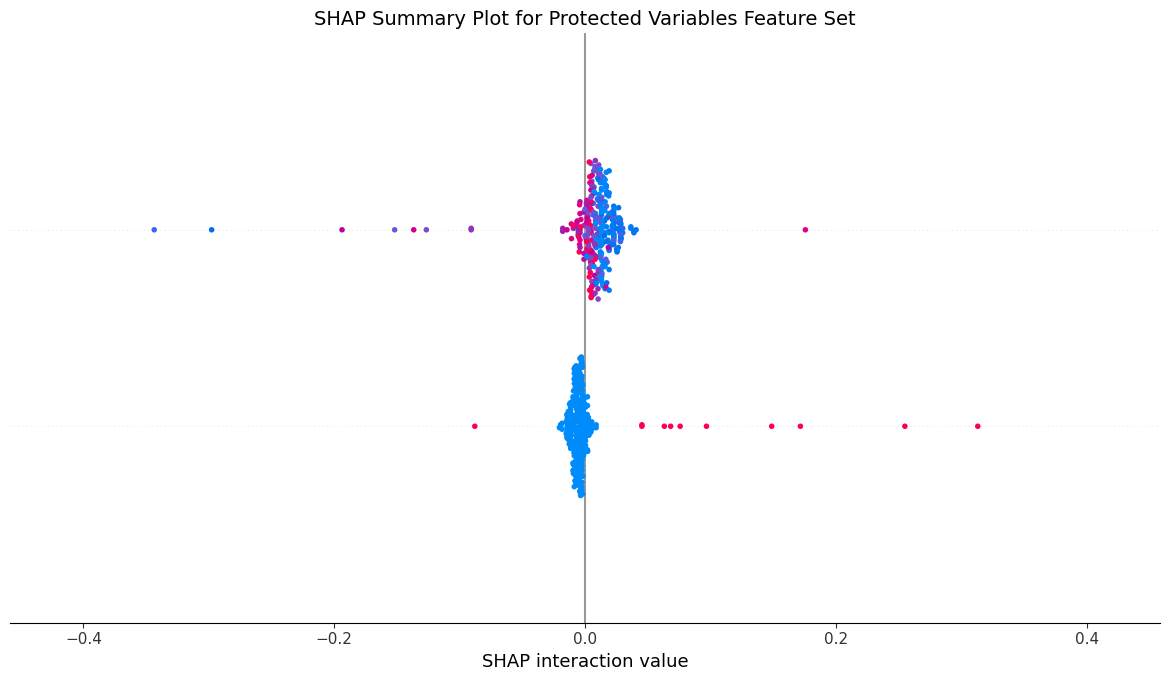

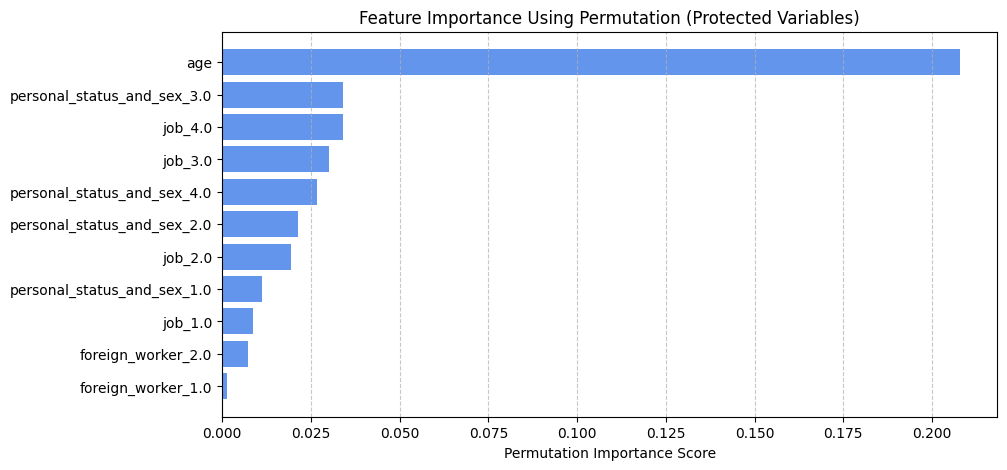

In [744]:
#Evaluate each feature set
importance_protected = evaluate_feature_importance(X, y, protected_vars, "Protected Variables")

/var/folders/ly/zhl3dp793873w6fqch3l_7g80000gn/T/ipykernel_48014/3529847050.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_subset, feature_names=X_subset.columns, show=False)  # Use directly if single output
/Users/dilara/.julia/conda/3/lib/python3.9/site-packages/shap/plots/_beeswarm.py:718: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/Users/dilara/.julia/conda/3/lib/python3.9/site-packages/shap/plots/_beeswarm.py:738: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` exp

<Figure size 1200x800 with 0 Axes>

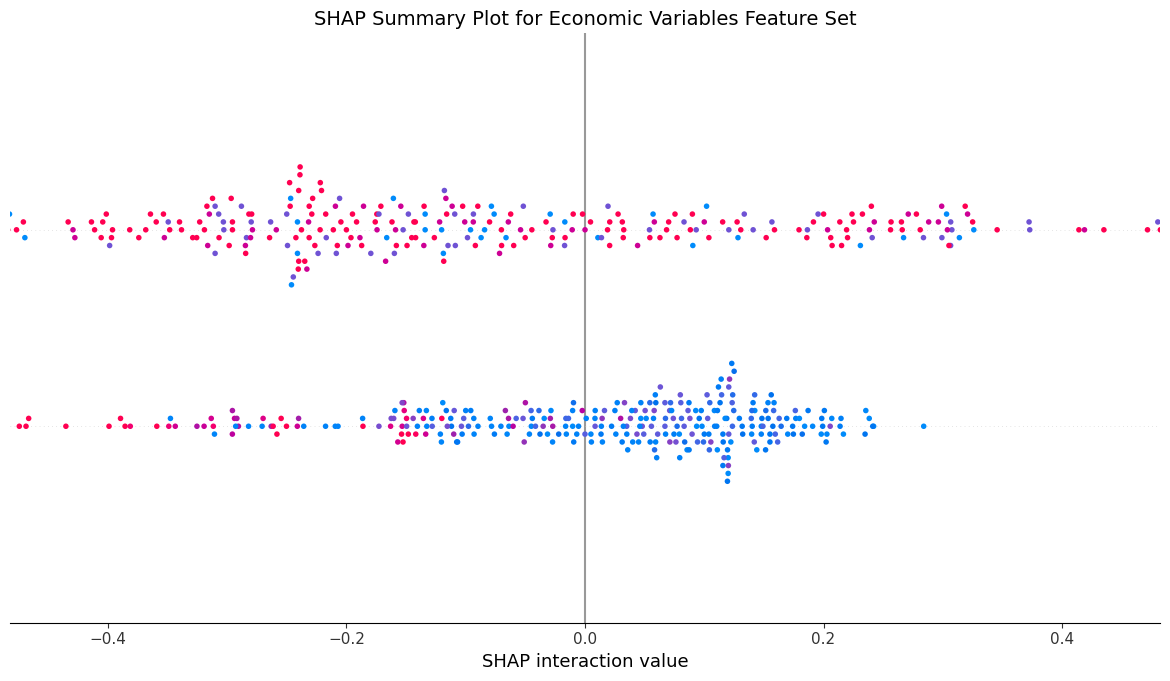

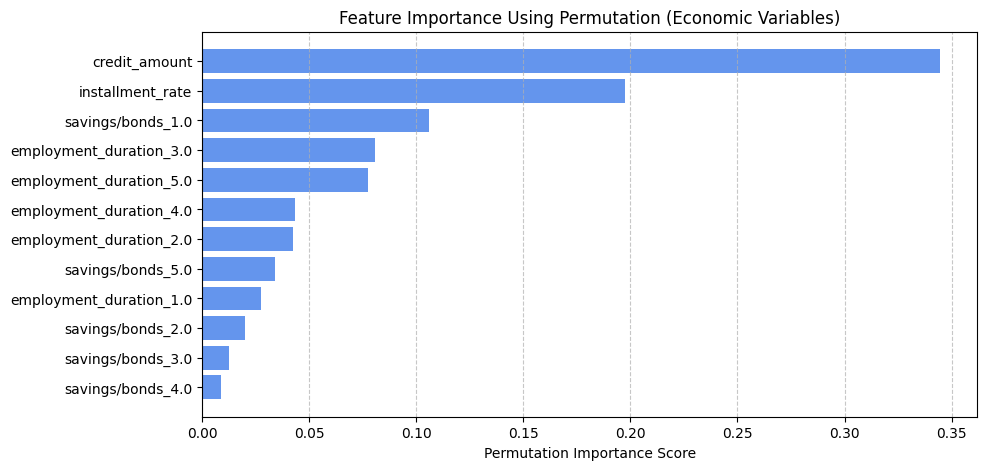

In [746]:
importance_economic = evaluate_feature_importance(X, y, economic_vars, "Economic Variables")


/var/folders/ly/zhl3dp793873w6fqch3l_7g80000gn/T/ipykernel_48014/3529847050.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_subset, feature_names=X_subset.columns, show=False)  # Use directly if single output
/Users/dilara/.julia/conda/3/lib/python3.9/site-packages/shap/plots/_beeswarm.py:718: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/Users/dilara/.julia/conda/3/lib/python3.9/site-packages/shap/plots/_beeswarm.py:738: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` exp

<Figure size 1200x800 with 0 Axes>

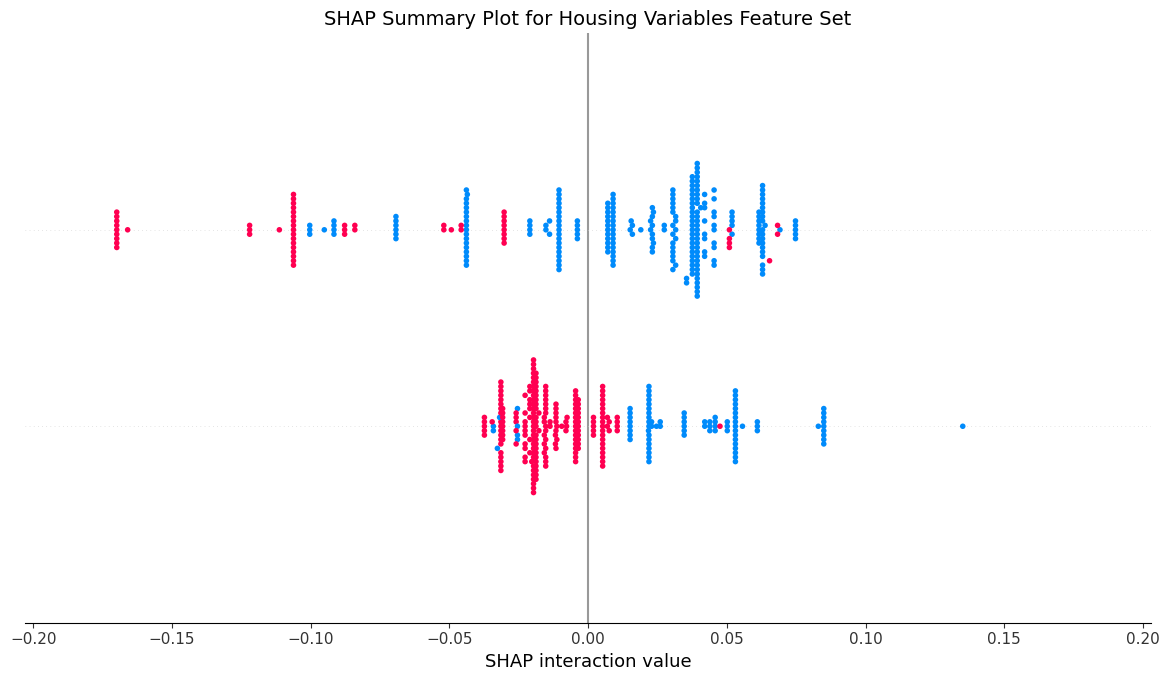

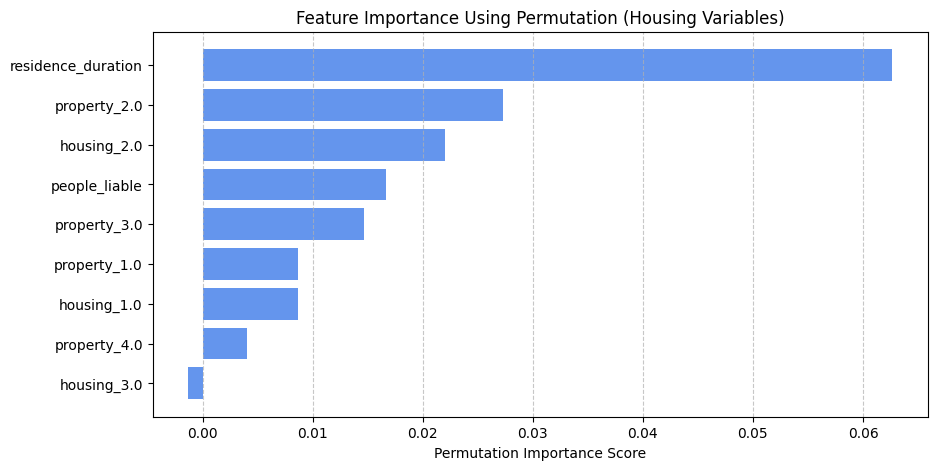

In [747]:
importance_housing = evaluate_feature_importance(X, y, housing_vars, "Housing Variables")


/var/folders/ly/zhl3dp793873w6fqch3l_7g80000gn/T/ipykernel_48014/3529847050.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_subset, feature_names=X_subset.columns, show=False)  # Use directly if single output
/Users/dilara/.julia/conda/3/lib/python3.9/site-packages/shap/plots/_beeswarm.py:718: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/Users/dilara/.julia/conda/3/lib/python3.9/site-packages/shap/plots/_beeswarm.py:738: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` exp

<Figure size 1200x800 with 0 Axes>

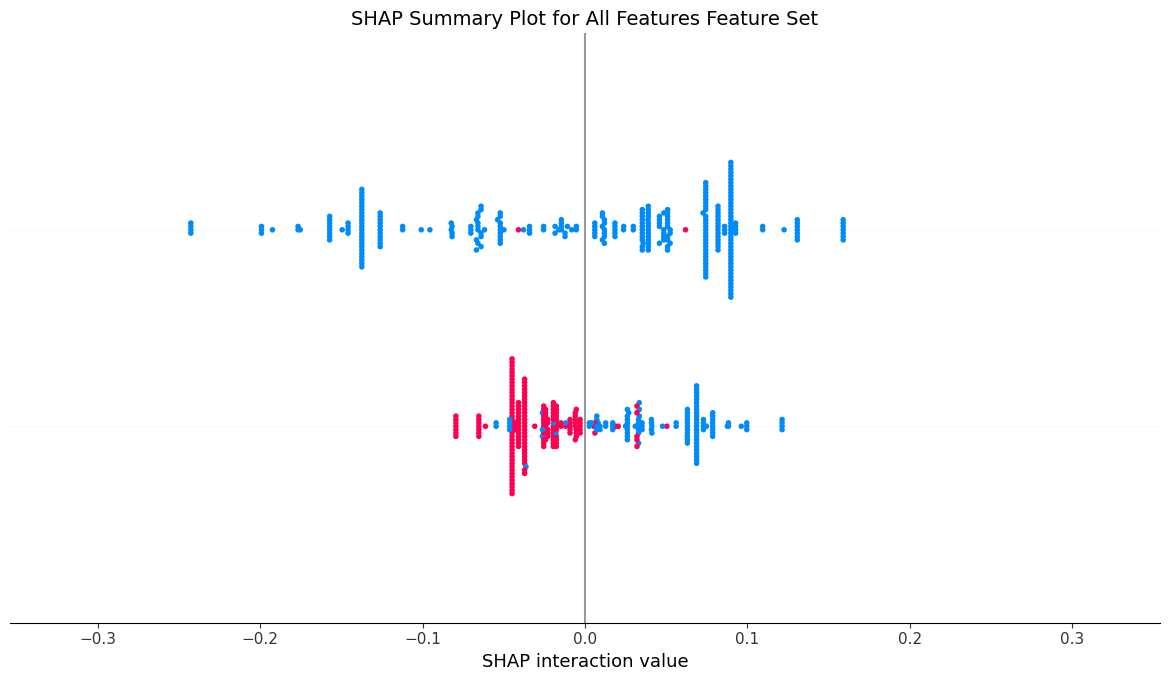

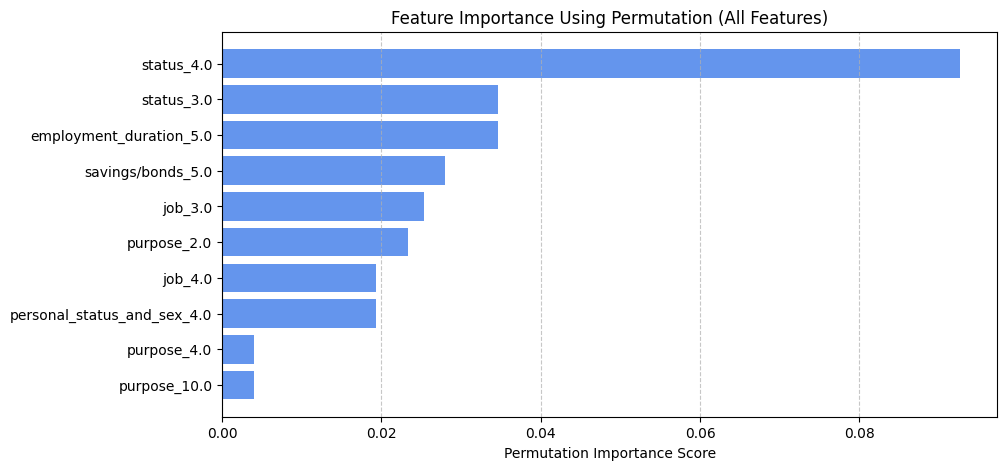

In [748]:
importance_all = evaluate_feature_importance(X, y, all_features[:10], "All Features")

> ## SHAP Global Explanations

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|█████████████████████████████████████████| 300/300 [03:57<00:00,  1.27it/s]
/var/folders/ly/zhl3dp793873w6fqch3l_7g80000gn/T/ipykernel_48014/1274085195.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap)


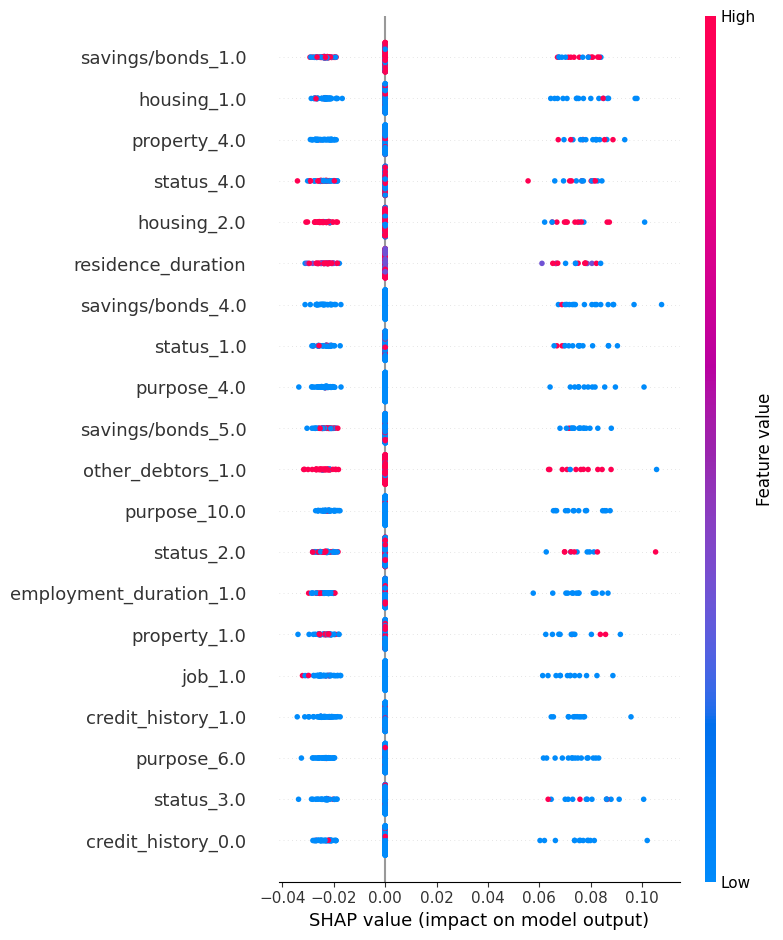

In [502]:
def predict_fn(data):
    indices = np.random.randint(0, len(y_pred), size=(data.shape[0],))
    return y_pred[indices] 

explainer = shap.KernelExplainer(predict_fn, X_shap)

#
shap_values = explainer.shap_values(X_shap)

# Feature Importance
shap.summary_plot(shap_values, X_shap)

/var/folders/ly/zhl3dp793873w6fqch3l_7g80000gn/T/ipykernel_48014/1354303612.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, top_10_indices], X.iloc[:, top_10_indices])


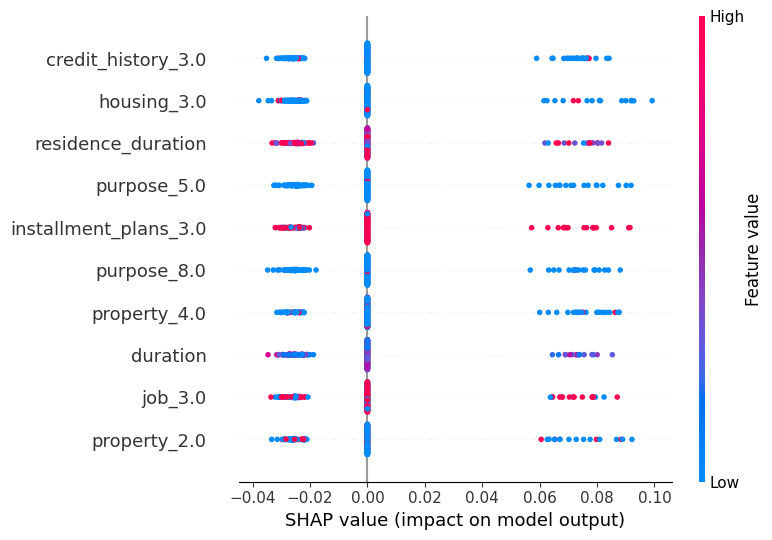

In [193]:
feature_importance = np.abs(shap_values).mean(axis=0)

# Get top 10 most impactful features
top_10_indices = np.argsort(feature_importance)[-10:]  # Last 10 are the highest
top_10_features = X.columns[top_10_indices]

# Create a DataFrame for top 10 features
top_10_df = pd.DataFrame({
    "Feature": top_10_features,
    "Mean |SHAP|": feature_importance[top_10_indices]
}).sort_values(by="Mean |SHAP|", ascending=False)


# Plot only top 10 features
shap.summary_plot(shap_values[:, top_10_indices,1], X.iloc[:, top_10_indices,1])


/var/folders/ly/zhl3dp793873w6fqch3l_7g80000gn/T/ipykernel_48014/2283252979.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="SHAP Value", y="Feature", data=shap_long, inner="quartile", palette="viridis")


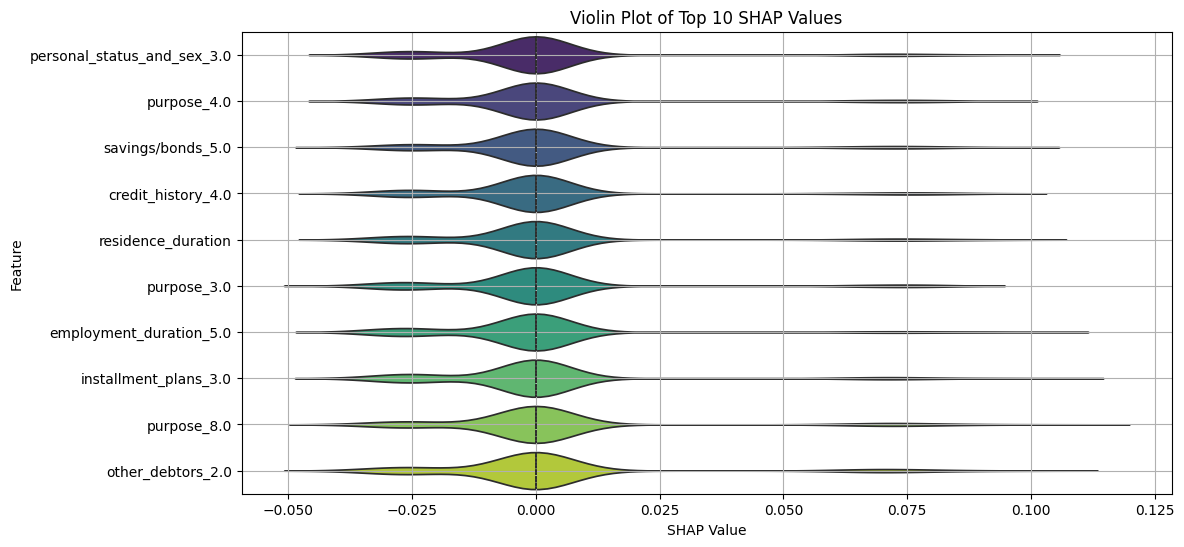

In [135]:
shap_long = shap_top_10.melt(var_name="Feature", value_name="SHAP Value")

#plot violin plots
plt.figure(figsize=(12, 6))
sns.violinplot(x="SHAP Value", y="Feature", data=shap_long, inner="quartile", palette="viridis")
plt.title("Violin Plot of Top 10 SHAP Values")
plt.xlabel("SHAP Value")
plt.ylabel("Feature")
plt.grid()
plt.show()

In [450]:
shap_values.shape

(300, 48)

In [452]:
shap_values

array([[ 0.        ,  0.        ,  0.        , ..., -0.02711177,
         0.        ,  0.        ],
       [ 0.        , -0.02697923,  0.        , ..., -0.02927804,
        -0.0215078 ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.0716823 ,  0.07273086,  0.05903133, ...,  0.        ,
         0.        ,  0.        ],
       [-0.0245657 ,  0.        ,  0.        , ...,  0.        ,
        -0.02920392, -0.0276954 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [454]:
# Sort features by importance
shap_importance = np.abs(shap_values).mean(axis=0)
sorted_indices = np.argsort(shap_importance)[::-1]
top_features = X_shap.columns[sorted_indices][:15]  # Top 15 features
top_importance = shap_importance[sorted_indices][:15]

In [464]:
X_shap.shape

(300, 48)

In [466]:
# Convert y_pred to probability estimates
y_proba = np.zeros((len(y_pred), 2))  # Create a 2D array for probabilities
y_proba[:, 1] = y_pred  # Assign y_pred as probability for class 1
y_proba[:, 0] = 1 - y_pred  # Compute probability for class 0

# Define a function that mimics predict_proba (returns probabilities)
def predict_proba_fn(X_input):
    idx = np.random.choice(len(y_proba), size=X_input.shape[0], replace=True)  # Ensure shape consistency
    return y_proba[idx]  # Return class probabilities

# Use a small baseline sample instead of k-means clustering
X_baseline = X_shap.sample(n=10, random_state=42)  # Select 10 random baseline samples

# Create SHAP Kernel Explainer
explainer = shap.KernelExplainer(predict_proba_fn, X_baseline)

100%|█████████████████████████████████████████| 300/300 [00:20<00:00, 14.51it/s]
/var/folders/ly/zhl3dp793873w6fqch3l_7g80000gn/T/ipykernel_48014/2715469.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap)


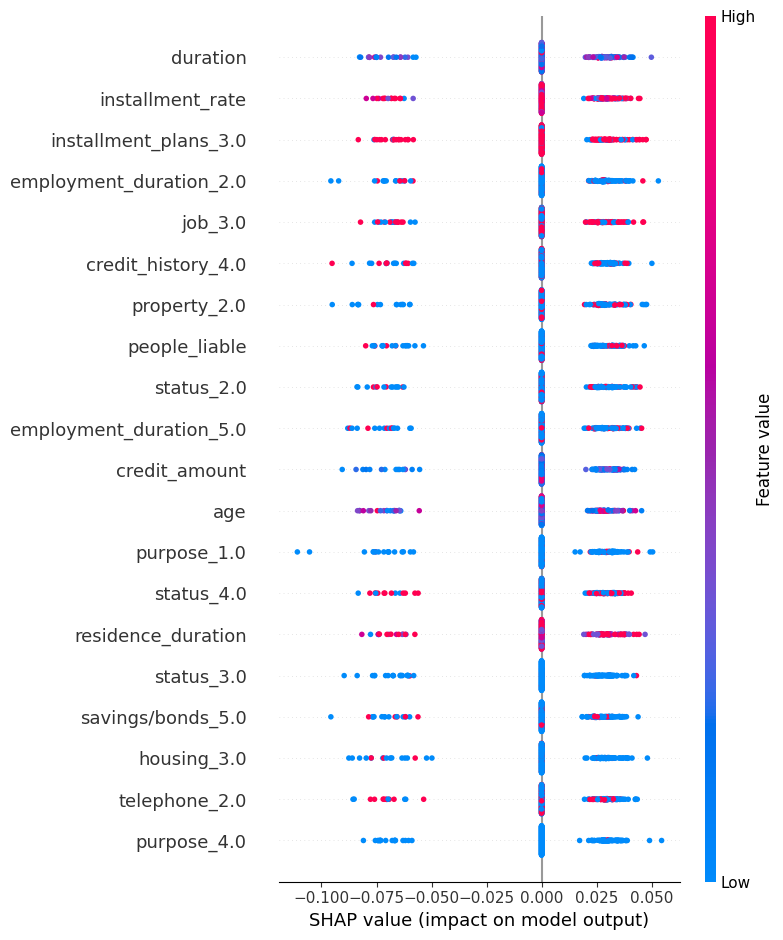

In [462]:
# Compute SHAP values for Class 0 (Creditworthy)
shap_values = explainer.shap_values(X_shap)[:,:,0]

# Generate SHAP Summary Plot
shap.summary_plot(shap_values, X_shap)

100%|█████████████████████████████████████████| 300/300 [00:19<00:00, 15.42it/s]
/var/folders/ly/zhl3dp793873w6fqch3l_7g80000gn/T/ipykernel_48014/2353456849.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap)


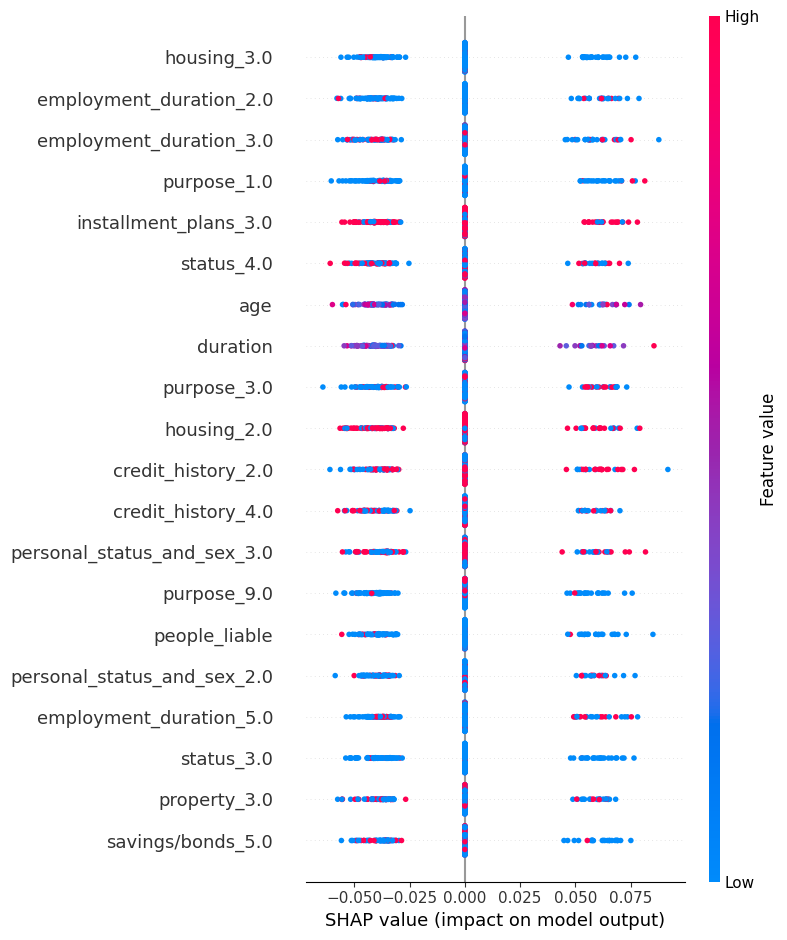

In [470]:
# Compute SHAP values for Class 1 (Non-Creditworthy)
shap_values = explainer.shap_values(X_shap)[:,:,1] 

# Generate SHAP Summary Plot
shap.summary_plot(shap_values, X_shap)

In [215]:
X

,duration,credit_amount,installment_rate,residence_duration,age,number_of_credits,people_liable,status_2.0,status_3.0,status_4.0,...,property_4.0,installment_plans_2.0,installment_plans_3.0,housing_2.0,housing_3.0,job_2.0,job_3.0,job_4.0,telephone_2.0,foreign_worker_2.0
0,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,True,False,False,...,False,False,True,True,False,False,True,False,False,False
1,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,False,False,True,...,False,False,True,True,False,True,False,False,False,False
2,24.0,2835.0,3.0,4.0,53.0,1.0,1.0,False,False,True,...,False,False,True,True,False,False,True,False,False,False
3,48.0,4308.0,3.0,4.0,24.0,1.0,1.0,False,False,False,...,False,False,True,False,False,False,True,False,False,False
4,24.0,1199.0,4.0,4.0,60.0,2.0,1.0,False,False,False,...,False,False,True,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,24.0,6579.0,4.0,2.0,29.0,1.0,1.0,False,False,False,...,True,False,True,False,True,False,False,True,True,False
296,18.0,1936.0,2.0,4.0,23.0,2.0,1.0,False,False,False,...,False,False,True,False,False,True,False,False,False,False
297,36.0,3959.0,4.0,3.0,30.0,1.0,1.0,False,False,False,...,False,False,True,True,False,False,False,True,True,False
298,30.0,3857.0,4.0,4.0,40.0,1.0,1.0,False,False,False,...,False,False,True,True,False,False,False,True,True,False


> ## Partial Dependence Plot (PDP) - ALE

In [220]:
# Fit a simple model to approximate y_pred
proxy_model = RandomForestRegressor(n_estimators=50, random_state=42)
proxy_model.fit(X, y_pred)

# Alternative: Use Linear Regression (if the relationship is linear)
# proxy_model = LinearRegression().fit(X, y_pred)


RandomForestRegressor(n_estimators=50, random_state=42)

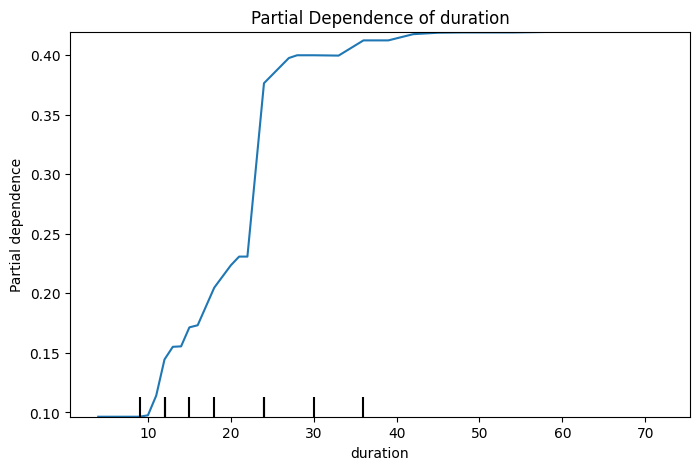

In [230]:
# Choose a feature to analyze
feature_to_plot = X.columns[0]  # Change this to your preferred feature

# Generate PDP
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(proxy_model, X, [feature_to_plot], ax=ax)
plt.title(f"Partial Dependence of {feature_to_plot}")
plt.show()


* Duration < 10: No strong effect on predictions.
* Duration 10-30: Strong positive impact on model predictions.
* Duration > 40: The effect flattens, meaning increasing "duration" beyond 40 doesn’t contribute further.

In [254]:
print(f"Available Features: {list(X.columns)}")

Available Features: ['duration', 'credit_amount', 'installment_rate', 'residence_duration', 'age', 'number_of_credits', 'people_liable', 'status_2.0', 'status_3.0', 'status_4.0', 'credit_history_1.0', 'credit_history_2.0', 'credit_history_3.0', 'credit_history_4.0', 'purpose_1.0', 'purpose_2.0', 'purpose_3.0', 'purpose_4.0', 'purpose_5.0', 'purpose_6.0', 'purpose_8.0', 'purpose_9.0', 'purpose_10.0', 'savings/bonds_2.0', 'savings/bonds_3.0', 'savings/bonds_4.0', 'savings/bonds_5.0', 'employment_duration_2.0', 'employment_duration_3.0', 'employment_duration_4.0', 'employment_duration_5.0', 'personal_status_and_sex_2.0', 'personal_status_and_sex_3.0', 'personal_status_and_sex_4.0', 'other_debtors_2.0', 'other_debtors_3.0', 'property_2.0', 'property_3.0', 'property_4.0', 'installment_plans_2.0', 'installment_plans_3.0', 'housing_2.0', 'housing_3.0', 'job_2.0', 'job_3.0', 'job_4.0', 'telephone_2.0', 'foreign_worker_2.0']


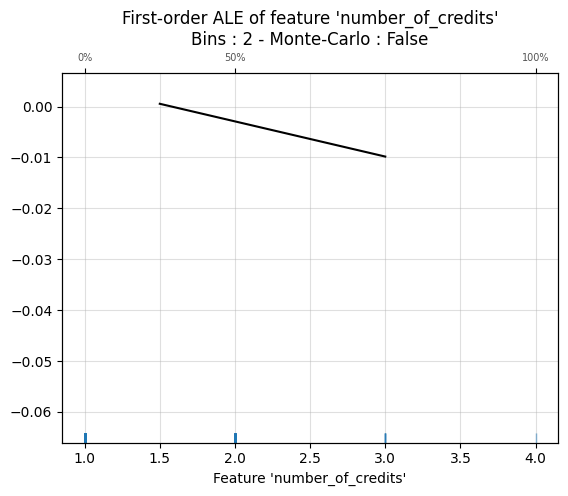

<Axes: title={'center': "First-order ALE of feature 'number_of_credits'\nBins : 2 - Monte-Carlo : False"}, xlabel="Feature 'number_of_credits'">

In [288]:
# Choose a feature name from X.columns
feature_name = "number_of_credits"  # Ensure it's correct

# Ensure the feature exists
if feature_name not in X.columns:
    raise ValueError(f"Feature '{feature_name}' not found in X.columns!")

# Generate ALE plot (avoid extra plt.show())
alepython.ale.ale_plot(proxy_model, X, feature_name)  


- The **slope is slightly decreasing**, meaning as `"number_of_credits"` increases, the model’s prediction **decreases slightly**.
- The **effect is very small** (Y-axis values between **0.00 and -0.06**), so this feature has a **weak impact** on predictions.
- The **blue ticks on the X-axis** show that most data points have **1 or 2 credits**, making the model more confident in this range.

- If this is a **credit risk model**, having **more credits might slightly lower the predicted risk**.
- However, since the effect is small, `"number_of_credits"` is **not a major driver** of predictions.

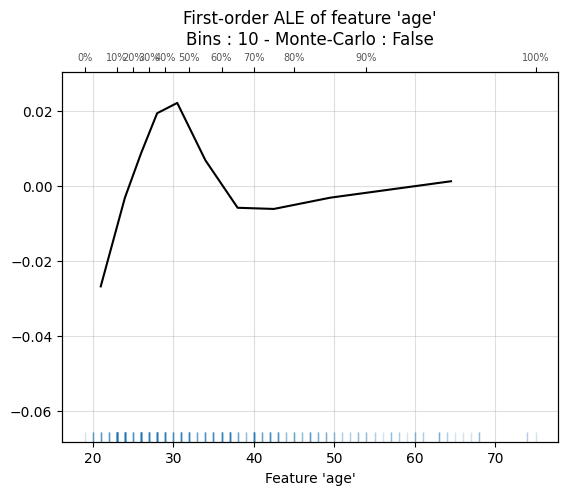

<Axes: title={'center': "First-order ALE of feature 'age'\nBins : 10 - Monte-Carlo : False"}, xlabel="Feature 'age'">

In [264]:

# Choose a feature name from X.columns
feature_name = "age"  # Ensure it's correct

# Ensure the feature exists
if feature_name not in X.columns:
    raise ValueError(f"Feature '{feature_name}' not found in X.columns!")

# Generate ALE plot (avoid extra plt.show())
alepython.ale.ale_plot(proxy_model, X, feature_name)  
